<h1 style="color:#27469c"> Improved ESB Tower 1 Model </h1>

<b>Summer 2023</b>: Getting used to working with keras using the same dataset

1. Recreating the ESB Tower 1 model in keras (using LSTM) instead of scikit learn
2. Generalizing code

Following https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

<h2 style="color:#27469c">Load packages and data</h2>

In [7]:
# Load Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

In [8]:
# load cleaned up dataset from spring project
datapath = 'data/'
df = pd.read_csv(f'{datapath}/results/prepared_data.csv', index_col='time')

# set index column as datetime object (dealing with timeseries data)
df.index.name = 'time'
df.index = pd.to_datetime(df.index)

# copied features and target from esb1-model
features = ['ESB_Tower_1 enteringWaterTemp', 'ESB_Tower_1 outdoorAirHumidity', 'ESB_Tower_1 outdoorAirDryBulb', 'ESB_Tower_1 outdoorAirWetBulb', 'Cell_1aFan vfdPercent', 'leavingWaterTemp_ratio', 'efficiency_rolling_mean']
targets = ['ESB_Tower_1 leavingWaterTemp']

# create final dataframe that includes only relevant features and targets
df = df[features].join(df[targets], on='time')

<h2 style="color:#27469c">Frame time series as a supervised learning dataset</h2>

In [9]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True, target_names=df.columns):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    target_names: List of target variables to be predicted
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f"{df.columns[j]}(t-{i})") for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[target_names].shift(-i))
        print(target_names)
        if i == 0:
            names += [(f"{df.columns[j]}(t)") for j in range(n_vars) if df.columns[j] in target_names]
        else:
            names += [(f"{df.columns[j]}(t+{i})") for j in range(n_vars) if df.columns[j] in target_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
# load dataset as array
values = df.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(values), columns=df.columns, index=df.index)

# frame time series dataset for supervised learning
reframed_df = series_to_supervised(scaled_df, 1, 1, target_names=['ESB_Tower_1 leavingWaterTemp'])
reframed_df

['ESB_Tower_1 leavingWaterTemp']


,ESB_Tower_1 enteringWaterTemp(t-1),ESB_Tower_1 outdoorAirHumidity(t-1),ESB_Tower_1 outdoorAirDryBulb(t-1),ESB_Tower_1 outdoorAirWetBulb(t-1),Cell_1aFan vfdPercent(t-1),leavingWaterTemp_ratio(t-1),efficiency_rolling_mean(t-1),ESB_Tower_1 leavingWaterTemp(t-1),ESB_Tower_1 leavingWaterTemp(t)
time,,,,,,,,,
2019-05-17 16:45:00+00:00,0.537222,0.368177,0.807534,0.813007,1.000000,0.508960,0.439184,0.345625,0.345625
2019-05-17 16:50:00+00:00,0.713371,0.375339,0.807534,0.812377,1.000000,0.508960,0.439189,0.345625,0.345625
2019-05-17 16:55:00+00:00,0.723823,0.378388,0.807534,0.815557,1.000000,0.508960,0.439210,0.345625,0.345625
2019-05-17 17:00:00+00:00,0.714243,0.377786,0.807534,0.819851,1.000000,0.234676,0.439219,0.345625,0.345625
2019-05-17 17:05:00+00:00,0.694587,0.358970,0.807534,0.812134,1.000000,0.234676,0.439208,0.345625,0.345625
...,...,...,...,...,...,...,...,...,...
2020-01-01 04:40:00+00:00,0.179032,0.364278,0.301938,0.297816,0.026044,0.221217,0.319331,0.208596,0.208596
2020-01-01 04:50:00+00:00,0.179127,0.352227,0.301938,0.297285,0.032557,0.221217,0.319229,0.208596,0.208596
2020-01-01 05:00:00+00:00,0.179106,0.351676,0.305736,0.299281,0.025657,0.221217,0.319126,0.208596,0.208596


<h2 style="color:#27469c">Split into Training and Testing</h2>

In [11]:
tss = TimeSeriesSplit(n_splits = 3)
X = reframed_df.drop([f'{target}(t)' for target in targets], axis=1) # drop target columns
y = reframed_df[[f'{target}(t)' for target in targets]] # only have target columns

for train_index, test_index in tss.split(X): # split into training and testing
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = X_train.values
test_X = X_test.values
train_y = y_train.values
test_y = y_test.values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(30291, 1, 8) (30291, 1) (10097, 1, 8) (10097, 1)


<h2 style="color:#27469c">Create and Train Model</h2>

In [13]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

2023-06-12 13:12:13.369439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
421/421 - 2s - loss: 0.0428 - val_loss: 0.1073 - 2s/epoch - 5ms/step
Epoch 2/50
421/421 - 1s - loss: 0.0394 - val_loss: 0.0958 - 648ms/epoch - 2ms/step
Epoch 3/50
421/421 - 1s - loss: 0.0379 - val_loss: 0.0919 - 629ms/epoch - 1ms/step
Epoch 4/50
421/421 - 1s - loss: 0.0366 - val_loss: 0.0822 - 644ms/epoch - 2ms/step
Epoch 5/50
421/421 - 1s - loss: 0.0348 - val_loss: 0.0773 - 653ms/epoch - 2ms/step
Epoch 6/50
421/421 - 1s - loss: 0.0340 - val_loss: 0.0675 - 728ms/epoch - 2ms/step
Epoch 7/50
421/421 - 1s - loss: 0.0316 - val_loss: 0.0634 - 698ms/epoch - 2ms/step
Epoch 8/50
421/421 - 1s - loss: 0.0304 - val_loss: 0.0578 - 628ms/epoch - 1ms/step
Epoch 9/50
421/421 - 1s - loss: 0.0283 - val_loss: 0.0545 - 609ms/epoch - 1ms/step
Epoch 10/50
421/421 - 1s - loss: 0.0272 - val_loss: 0.0517 - 615ms/epoch - 1ms/step
Epoch 11/50
421/421 - 1s - loss: 0.0260 - val_loss: 0.0488 - 628ms/epoch - 1ms/step
Epoch 12/50
421/421 - 1s - loss: 0.0253 - val_loss: 0.0464 - 639ms/epoch - 2ms/step
Epoc

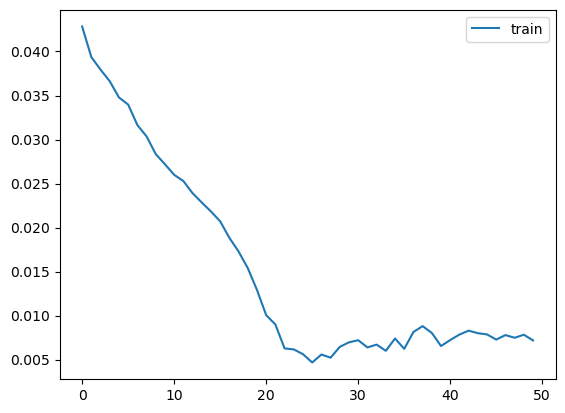

In [15]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

316/316 [==============================] - 0s 636us/step


In [18]:
# calculate RMSE
mabs_error = mean_absolute_error(test_y, yhat)
msq_error = mean_squared_error(test_y, yhat)

rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Mean absolute error on normalized data: %.3f' % mabs_error)
print('Mean squared error on normalized data: %.3f' % msq_error)
print('Test RMSE: %.3f' % rmse)

Mean absolute error on normalized data: 0.007
Mean squared error on normalized data: 0.000
Test RMSE: 0.008
